## Exploration

This notebook is divided into two parts, exploration and analysis in which we clean and analyse the data indepth inorder to give a clear recomendation

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sqlite3


In [70]:
conn = sqlite3.connect('im.db')

pd.options.display.float_format = '{:,.0f}'.format

In [71]:
cur = conn.cursor()

cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

## 1. Data Exploration and Cleaning

These three are per the datasets descibed in analysis.ipynb and note that we use sqlite to open im.db as it is a sqlite3 db

In [72]:
# get data
imdb_basics = pd.read_sql_query('SELECT * FROM movie_basics', conn)
imdb_ratings = pd.read_sql_query('SELECT * FROM movie_ratings', conn)
bom_movies_gross = pd.read_csv('bom.movie_gross.csv')

To get a better sense of what is in this dataset, we will have to go back to analysis.ipynb under the business problem, and we see that this is a company that has no idea of what this industry is about. With that, it's safe to say we need data that is full, which describes each film well, and that is the whole point of this section. We look at each dataframe individually and ask ourselves what this dataset has to offer that the others don't. So, what I have opted to do is to take pieces from each dataset, then combine them into one complete, somewhat clean dataframe that will give us a better sense of what we are to work with.

In [73]:
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [74]:
imdb_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80,"Comedy,Drama,Fantasy"


From this we can already see that 'primary_title' and 'original_title' differ, and with that we will opt to use 'primary_title' from here on out. To get a better sense of what I am saying, you can look at the cell below.



In [75]:
imdb_basics[imdb_basics['primary_title'] != imdb_basics['original_title']]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114,"Biography,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80,"Comedy,Drama,Fantasy"
11,tt0154039,So Much for Justice!,Oda az igazság,2010,100,History
13,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89,Drama
15,tt0176694,The Tragedy of Man,Az ember tragédiája,2011,160,"Animation,Drama,History"
...,...,...,...,...,...,...
146026,tt9899938,Journey of the Sky Goddess,Kibaiyanse! Watashi,2019,116,"Comedy,Drama"
146028,tt9900060,Lupin the Third: Fujiko Mine's Lie,Lupin the IIIrd: Mine Fujiko no Uso,2019,nan,"Adventure,Crime,Drama"
146037,tt9900688,Big Three Dragons,Da San Yuan,2019,111,Comedy
146121,tt9914254,A Cherry Tale,Kirsebæreventyret,2019,85,Documentary


In [76]:

# drop 'original_title'

imdb_basics = imdb_basics.drop('original_title', axis=1)

In [77]:

imdb_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122,Drama
3,tt0069204,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy"



filling in missing values using the median inorder to maintain centrality of the data

In [78]:
median_runtime = imdb_basics['runtime_minutes'].median()
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].fillna(median_runtime)
imdb_basics['genres'] = imdb_basics['genres'].fillna('Unknown')
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  146144 non-null  float64
 4   genres           146144 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.6+ MB


## 2. Cleaning imdb_ratings

In [79]:
# ratings
imdb_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [80]:

imdb_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8,31
1,tt10384606,9,559
2,tt1042974,6,20
3,tt1043726,4,50352
4,tt1060240,6,21



From the cells above you can see no cleaning was nessesary so no action was taken.

## 3. Cleaning bom_movies_gross

In [81]:

# movies gross
bom_movies_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [82]:

bom_movies_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,"415,000,000",652000000,2010
1,Alice in Wonderland (2010),BV,"334,200,000",691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,"296,000,000",664300000,2010
3,Inception,WB,"292,600,000",535700000,2010
4,Shrek Forever After,P/DW,"238,700,000",513900000,2010


filling empty 'studio' values with 'Unknown'.

i opted to use 0 in 'foreign_gross' rather than median as a large number of the column was empty and filling it with the median would result in inaccurate analysis.

i did however use median in 'domestic_gross' as less than 1% of the data was missing.

In [83]:

# clean movies_gross
bom_movies_gross['studio'] = bom_movies_gross['studio'].fillna('Unknown')

# convert foreign gross to float
bom_movies_gross['foreign_gross'] = bom_movies_gross['foreign_gross'].fillna(0)
bom_movies_gross['foreign_gross'] = pd.to_numeric(bom_movies_gross['foreign_gross'], errors='coerce')

median_domestic = bom_movies_gross['domestic_gross'].median()
bom_movies_gross['domestic_gross'] = bom_movies_gross['domestic_gross'].fillna(median_domestic)

bom_movies_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3387 non-null   object 
 2   domestic_gross  3387 non-null   float64
 3   foreign_gross   3382 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


## 4. Combining the cleaned dataframes

Now we can combine the best of three to start to analyse

In [84]:
joined_imdb = pd.merge(imdb_basics, imdb_ratings, on='movie_id', how='inner')

In [85]:

joined_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   start_year       73856 non-null  int64  
 3   runtime_minutes  73856 non-null  float64
 4   genres           73856 non-null  object 
 5   averagerating    73856 non-null  float64
 6   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 4.5+ MB


In [86]:
movies = pd.merge(joined_imdb, bom_movies_gross, left_on='primary_title', right_on='title', how='inner')

In [87]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3027 entries, 0 to 3026
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3027 non-null   object 
 1   primary_title    3027 non-null   object 
 2   start_year       3027 non-null   int64  
 3   runtime_minutes  3027 non-null   float64
 4   genres           3027 non-null   object 
 5   averagerating    3027 non-null   float64
 6   numvotes         3027 non-null   int64  
 7   title            3027 non-null   object 
 8   studio           3027 non-null   object 
 9   domestic_gross   3027 non-null   float64
 10  foreign_gross    3023 non-null   float64
 11  year             3027 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 307.4+ KB


## 2. Analysis

Now that our data is cleaned and organized, we can now analyse our data based on gross value and popularity:

1. Most successful studios
2. Most successful genres
3. Trends overtime
4. Runtime of succesful films

In [88]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3027 entries, 0 to 3026
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3027 non-null   object 
 1   primary_title    3027 non-null   object 
 2   start_year       3027 non-null   int64  
 3   runtime_minutes  3027 non-null   float64
 4   genres           3027 non-null   object 
 5   averagerating    3027 non-null   float64
 6   numvotes         3027 non-null   int64  
 7   title            3027 non-null   object 
 8   studio           3027 non-null   object 
 9   domestic_gross   3027 non-null   float64
 10  foreign_gross    3023 non-null   float64
 11  year             3027 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 307.4+ KB


## 1. Most successful studios

Why most successful studios? I presume that the company would want to know who the big players in the industry are in order to know what they are up against and for them to use the data analysed as a benchmark of what is to be expected of a good studio.

In [89]:
studio_performance = movies.groupby('studio').agg(
    total_films=('title', 'count'),
    avg_domestic_gross=('domestic_gross', 'mean'),
    avg_foreign_gross=('foreign_gross', 'mean'),
    total_domestic_gross=('domestic_gross', 'sum'),
    total_foreign_gross=('foreign_gross', 'sum')
).sort_values(by='total_domestic_gross', ascending=False)

In [90]:
top_studios = studio_performance.head(20)
top_studios

,total_films,avg_domestic_gross,avg_foreign_gross,total_domestic_gross,total_foreign_gross
studio,,,,,
BV,97,"175,240,206","266,358,833","16,998,299,999","25,570,448,000"
Uni.,156,"88,406,397","117,863,190","13,791,398,000","18,033,067,999"
Fox,138,"79,386,232","141,452,657","10,955,299,998","19,520,466,599"
WB,119,"89,799,160","129,470,613","10,686,100,000","15,407,002,998"
Par.,90,"82,253,474","118,619,633","7,402,812,699","10,675,766,997"
Sony,89,"78,568,062","126,146,281","6,992,557,497","11,227,018,999"
WB (NL),54,"83,983,333","121,027,778","4,535,099,999","6,535,500,000"
LGF,91,"40,711,543","50,825,553","3,704,750,400","4,625,125,300"
P/DW,10,"168,290,000","339,360,000","1,682,900,000","3,393,600,000"


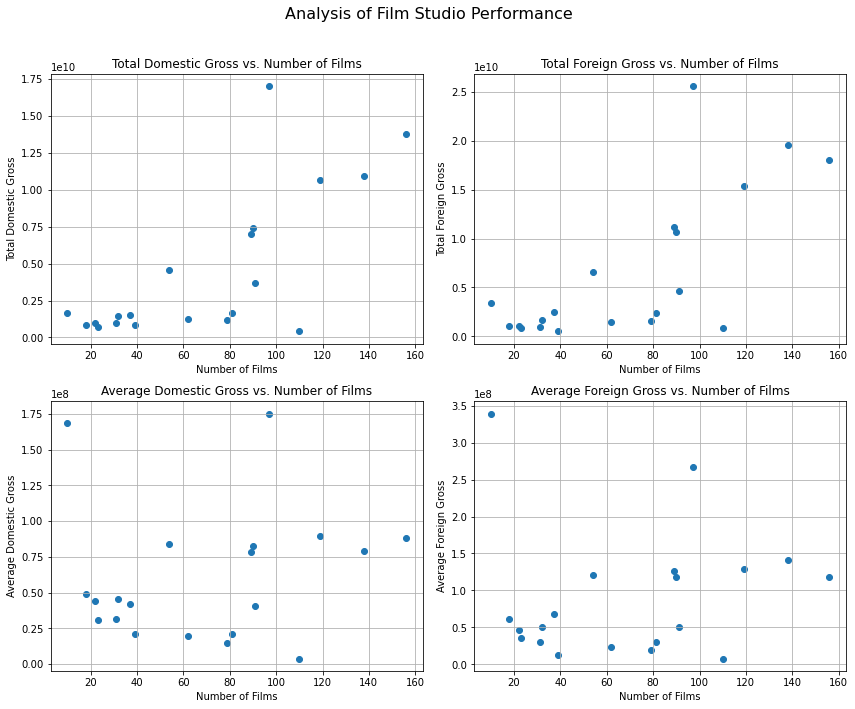

In [91]:
studio_names = top_studios.index
film_numbers = top_studios.total_films
total_domestic_gross = top_studios.total_domestic_gross
total_foreign_gross = top_studios.total_foreign_gross
avg_domestic_gross = top_studios.avg_domestic_gross
avg_foreign_gross = top_studios.avg_foreign_gross

fig, ((domestic_total, foreign_total), (domestic_avg, foreign_avg)) = plt.subplots(figsize=(12, 10), nrows=2, ncols=2)

# Set a title for the entire figure
fig.suptitle('Analysis of Film Studio Performance', fontsize=16)

# Plot for Total Domestic Gross vs. Number of Films
domestic_total.scatter(x=film_numbers, y=total_domestic_gross)
domestic_total.set_title('Total Domestic Gross vs. Number of Films')
domestic_total.set_xlabel('Number of Films')
domestic_total.set_ylabel('Total Domestic Gross')
domestic_total.grid(True)

# Plot for Total Foreign Gross vs. Number of Films
foreign_total.scatter(x=film_numbers, y=total_foreign_gross)
foreign_total.set_title('Total Foreign Gross vs. Number of Films')
foreign_total.set_xlabel('Number of Films')
foreign_total.set_ylabel('Total Foreign Gross')
foreign_total.grid(True)

# Plot for Average Domestic Gross vs. Number of Films
domestic_avg.scatter(x=film_numbers, y=avg_domestic_gross)
domestic_avg.set_title('Average Domestic Gross vs. Number of Films')
domestic_avg.set_xlabel('Number of Films')
domestic_avg.set_ylabel('Average Domestic Gross')
domestic_avg.grid(True)

# Plot for Average Foreign Gross vs. Number of Films
foreign_avg.scatter(x=film_numbers, y=avg_foreign_gross)
foreign_avg.set_title('Average Foreign Gross vs. Number of Films')
foreign_avg.set_xlabel('Number of Films')
foreign_avg.set_ylabel('Average Foreign Gross')
foreign_avg.grid(True)

# Improve layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

In [92]:
# corelations:
correlations = top_studios.corr()
corr_total_domestic = correlations.loc['total_films', 'total_domestic_gross']
corr_total_foreign = correlations.loc['total_films', 'total_foreign_gross']
corr_avg_domestic = correlations.loc['total_films', 'avg_domestic_gross']
corr_avg_foreign = correlations.loc['total_films', 'avg_foreign_gross']

print(f"Correlation between Total Films and Total Domestic Gross: {corr_total_domestic:.2f}")
print(f"Correlation between Total Films and Total Foreign Gross: {corr_total_foreign:.2f}")
print(f"Correlation between Total Films and Average Domestic Gross: {corr_avg_domestic:.2f}")
print(f"Correlation between Total Films and Average Foreign Gross: {corr_avg_foreign:.2f}")

Correlation between Total Films and Total Domestic Gross: 0.73
Correlation between Total Films and Total Foreign Gross: 0.72
Correlation between Total Films and Average Domestic Gross: 0.14
Correlation between Total Films and Average Foreign Gross: 0.10


## 2. Most successful genres

Goal of this section is to identify now which of the many genres out there the company should start with.

In [93]:
movies['total_gross'] = movies['domestic_gross'] + movies['foreign_gross']

film_genres = movies.groupby('genres').agg(
    avg_ratings=('averagerating', 'mean'),
    avg_votes=('numvotes', 'mean'),
    total_gross=('total_gross', 'sum')
).sort_values(by='avg_votes', ascending=False)
top_genres = film_genres.head(20)

In [94]:
top_genres

,avg_ratings,avg_votes,total_gross
genres,,,
"Adventure,Drama,Sci-Fi",8,"989,725","1,307,500,000"
"Adventure,Mystery,Sci-Fi",7,"538,720","403,400,000"
"Action,Adventure,Sci-Fi",7,"419,617","26,304,999,999"
"Mystery,Sci-Fi,Thriller",7,"406,532","421,900,000"
"Action,Adventure,Mystery",7,"399,703","288,800,000"
"Action,Mystery,Sci-Fi",7,"387,038","348,300,000"
"Adventure,Fantasy",7,"375,770","2,112,099,999"
"Action,Comedy,Fantasy",8,"339,338","47,600,000"
"Mystery,Thriller",7,"290,034","303,885,000"


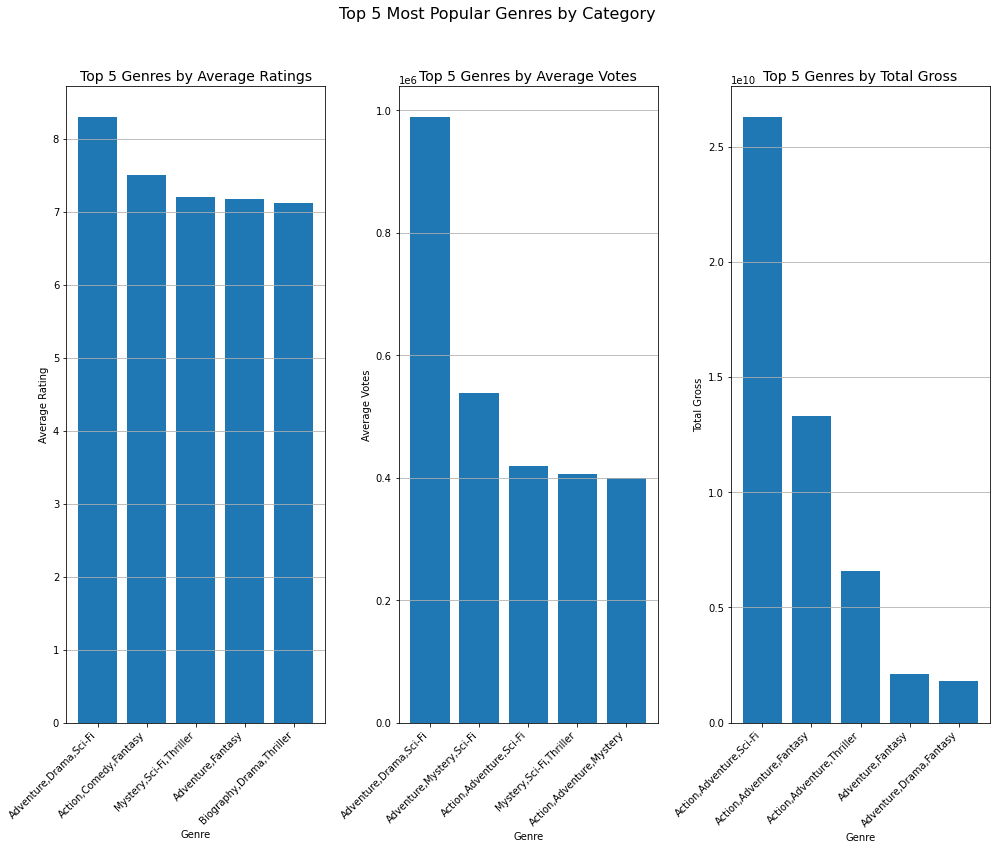

In [ ]:
# Top 5 genres for each metric
top_ratings = top_genres.sort_values('avg_ratings', ascending=False).head(5)
top_votes = top_genres.sort_values('avg_votes', ascending=False).head(5)
top_gross = top_genres.sort_values('total_gross', ascending=False).head(5)

fig, (ratings, votes, gross) = plt.subplots(figsize=(14, 12), ncols=3)

# Average Ratings vs Genres
ratings.bar(x=top_ratings.index, height=top_ratings['avg_ratings'])
ratings.set_title('Top 5 Genres by Average Ratings', fontsize=14)
ratings.set_ylabel('Average Rating')
ratings.set_xlabel('Genre')
ratings.set_xticks(range(len(top_ratings.index)))
ratings.set_xticklabels(top_ratings.index, rotation=45, ha='right')
ratings.grid(axis='y')

# Average Votes vs Genres
votes.bar(x=top_votes.index, height=top_votes['avg_votes'])
votes.set_title('Top 5 Genres by Average Votes', fontsize=14)
votes.set_ylabel('Average Votes')
votes.set_xlabel('Genre')
votes.set_xticks(range(len(top_votes.index)))
votes.set_xticklabels(top_votes.index, rotation=45, ha='right')
votes.grid(axis='y')

# Total Gross vs Genres
gross.bar(x=top_gross.index, height=top_gross['total_gross'])
gross.set_title('Top 5 Genres by Total Gross', fontsize=14)
gross.set_ylabel('Total Gross')
gross.set_xlabel('Genre')
gross.set_xticks(range(len(top_gross.index)))
gross.set_xticklabels(top_gross.index, rotation=45, ha='right')
gross.grid(axis='y')

fig.suptitle('Top 5 Most Popular Genres by Category', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

Now with this chart they know where to start from and just how much they are expected to get in return

## 3. Trends over time

Goal of this section is to know what is relevant in the current market of film

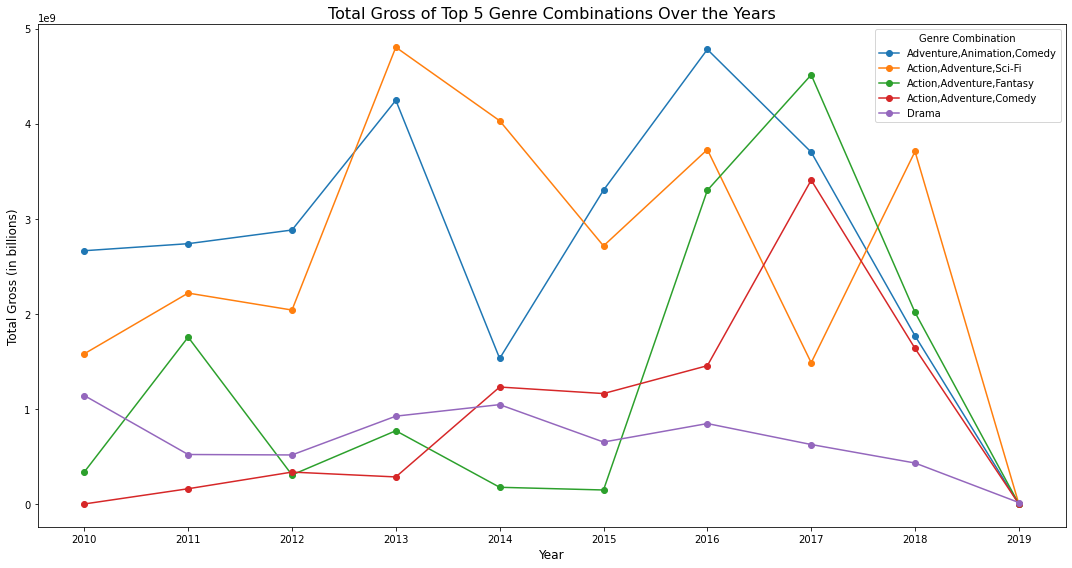

In [97]:
genre_trends = movies.groupby(['start_year', 'genres'])['total_gross'].sum()

top_5_genres = movies.groupby('genres')['total_gross'].sum().nlargest(5).index
# Filter the genre_trends Series to include only the top 5 genres
filtered_trends = genre_trends.loc[:, top_5_genres]

# Unstack the data to pivot the genres into columns for plotting
plot_data = filtered_trends.unstack(level='genres').fillna(0)

# Create the line plot
plt.figure(figsize=(15, 8))
for genre in top_5_genres:
    plt.plot(plot_data.index, plot_data[genre], marker='o', label=genre)

plt.title('Total Gross of Top 5 Genre Combinations Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Gross (in billions)', fontsize=12)
plt.xticks(plot_data.index)
plt.legend(title='Genre Combination')
plt.tight_layout()

---

with this it is evident that they should focus more on adventure, action, animation and comedy side

---

## 4. Runtime of succesful films

Goal is to know how long a typical succesful film should be (in minutes)

In [98]:
runtime_success = movies.groupby(['runtime_minutes', 'averagerating']).agg(
    total_gross=('total_gross', 'sum')
).sort_values(by='total_gross', ascending=False)

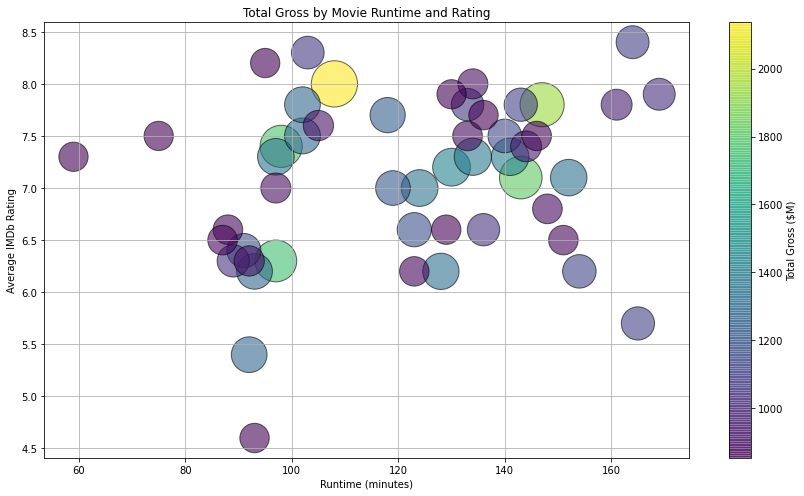

In [99]:
# Get top 50 profitable combinations
top_50 = runtime_success.head(50)

# Extract values
runtimes = top_50.index.get_level_values('runtime_minutes')
ratings = top_50.index.get_level_values('averagerating')
grosses = top_50['total_gross'] / 1e6  

plt.figure(figsize=(12, 7))
scatter = plt.scatter(runtimes, ratings, s=grosses, alpha=0.6, c=grosses, cmap='viridis', edgecolor='black')

plt.colorbar(scatter, label='Total Gross ($M)')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average IMDb Rating')
plt.title('Total Gross by Movie Runtime and Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
print("Median Rating:", np.median(ratings))
print("Median Runtime:", np.median(runtimes))
print("Median Gross:", np.median(grosses) * 1e6, "")

Median Rating: 7.3
Median Runtime: 126.0
Median Gross: 1076004500.0 
